In [1]:
# Import the relevant packages

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import cudaq
from cudaq import spin

In [4]:
# GPU utilities

cudaq.set_target("nvidia")  # Set CUDAQ to run on GPU's

torch.cuda.is_available(
)  # If this is True then the NVIDIA drivers are correctly installed

torch.cuda.device_count()  # Counts the number of GPU's available

torch.cuda.current_device()

torch.cuda.get_device_name(0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# Training set
sample_count = 140

X_train = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]),
)

# Leaving only labels 0 and 1
idx = np.append(
    np.where(X_train.targets == 0)[0][:sample_count],
    np.where(X_train.targets == 1)[0][:sample_count],
)

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

# Test set
sample_count = 70

X_test = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]),
)
idx = np.append(
    np.where(X_test.targets == 0)[0][:sample_count],
    np.where(X_test.targets == 1)[0][:sample_count],
)

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 16909686.63it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 63421829.23it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 4165068.04it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 11788693.54it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
class QuantumCircuit:
    """This class defines the quantum circuit structure and the run method which is used to calculate an expectation value"""

    def __init__(self, qubit_count: int):
        """Define the quantum circuit in CUDA Quantum"""

        kernel, thetas = cudaq.make_kernel(list)

        self.kernel = kernel

        self.theta = thetas

        qubits = kernel.qalloc(qubit_count)

        self.kernel.h(qubits)

        # Variational gate parameters which are optimised during training
        kernel.ry(thetas[0], qubits[0])
        kernel.rx(thetas[1], qubits[0])

    def run(self, thetas: torch.tensor) -> torch.tensor:
        """Excetute the quantum circuit to output an expectation value"""

        expectation = torch.tensor(cudaq.observe(self.kernel, spin.z(0),
                                                 thetas).expectation(),
                                   device=device)

        return expectation

In [7]:
class QuantumFunction(Function):
    """Allows the quantum circuit to pass data through it and compute the gradients"""

    @staticmethod
    def forward(ctx, thetas: torch.tensor, quantum_circuit,
                shift) -> torch.tensor:
        # Save shift and quantum_circuit in context to use in backward
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        # Calculate exp_val
        expectation_z = ctx.quantum_circuit.run(thetas)

        ctx.save_for_backward(thetas, expectation_z)

        return expectation_z

    @staticmethod
    def backward(ctx, grad_output):
        """Backward pass computation via finite difference parameter shift"""

        thetas, expectation_z = ctx.saved_tensors

        gradients = torch.zeros(len(thetas), device=device)

        for i in range(len(thetas)):
            shift_right = torch.clone(thetas)

            shift_right[i] += ctx.shift

            shift_left = torch.clone(thetas)

            shift_left[i] -= ctx.shift

            expectation_right = ctx.quantum_circuit.run(shift_right)
            expectation_left = ctx.quantum_circuit.run(shift_left)

            gradients[i] = 0.5 * (expectation_right - expectation_left)

        return gradients * grad_output.float(), None, None

In [8]:
class QuantumLayer(nn.Module):
    """Encapsulates a quantum circuit and a quantum function into a quantum layer"""

    def __init__(self, shift: torch.tensor):
        super(QuantumLayer, self).__init__()
        self.quantum_circuit = QuantumCircuit(1)  # 1 qubit quantum circuit
        self.shift = shift

    def forward(self, input):
        ans = QuantumFunction.apply(input, self.quantum_circuit, self.shift)

        return ans

In [9]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        # Neural network structure
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(
            64, 2
        )  # Output a 2D tensor since we have 2 variational parameters in our quantum circuit
        self.hybrid = QuantumLayer(
            torch.tensor(np.pi / 2)
        )  # Input is the magnitude of the parameter shifts to calculate gradients

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x).reshape(
            -1)  # Reshapes required to satisfy input dimensions to CUDAQ
        x = self.hybrid(x).reshape(-1)

        return torch.cat((x, 1 - x), -1).unsqueeze(0)

In [10]:
# We move our model to the CUDA device to minimise data transfer between GPU and CPU

model = Net().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_func = nn.NLLLoss().to(device)

epochs = 20

epoch_loss = []

model.train()
for epoch in range(epochs):
    batch_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):  # batch training
        optimizer.zero_grad()

        data, target = data.to(device), target.to(device)

        # Forward pass
        output = model(data).to(device)

        # Calculating loss
        loss = loss_func(output, target).to(device)

        # Backward pass
        loss.backward()

        # Optimize the weights
        optimizer.step()

        batch_loss += loss.item()

    epoch_loss.append(batch_loss / batch_idx)

    print("Training [{:.0f}%]\tLoss: {:.4f}".format(
        100.0 * (epoch + 1) / epochs, epoch_loss[-1]))

Training [5%]	Loss: -1.1650
Training [10%]	Loss: -1.3625
Training [15%]	Loss: -1.3716
Training [20%]	Loss: -1.3843
Training [25%]	Loss: -1.3996
Training [30%]	Loss: -1.4244
Training [35%]	Loss: -1.4381
Training [40%]	Loss: -1.4554
Training [45%]	Loss: -1.4567
Training [50%]	Loss: -1.4689
Training [55%]	Loss: -1.4760
Training [60%]	Loss: -1.4729
Training [65%]	Loss: -1.4757
Training [70%]	Loss: -1.4767
Training [75%]	Loss: -1.4852
Training [80%]	Loss: -1.4791
Training [85%]	Loss: -1.4891
Training [90%]	Loss: -1.4824
Training [95%]	Loss: -1.4891
Training [100%]	Loss: -1.4910


Text(0, 0.5, 'Neg Log Likelihood Loss')

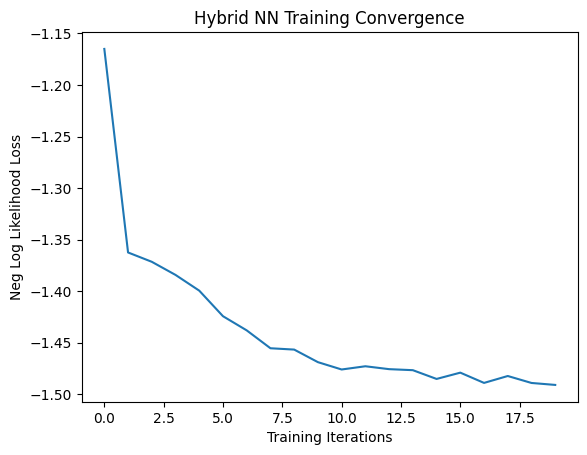

In [11]:
plt.plot(epoch_loss)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")

plt.ylabel("Neg Log Likelihood Loss")

In [12]:
# Testing on the test set

model.eval()
with torch.no_grad():
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)

        output = model(data).to(device)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        epoch_loss.append(loss.item())

    print("Performance on test data:\n\tAccuracy: {:.1f}%".format(
        correct / len(test_loader) * 100))

Performance on test data:
	Accuracy: 100.0%
